In [1]:
import os
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm
from PIL import Image

# FACET + CLIP
## Load annotations dataframe

In [2]:
# Read csv, sort by filename, and drop images that have more than one person 
df = pd.read_csv("../data/annotations/annotations.csv", index_col=0)
df['bounding_box'] = df['bounding_box'].apply(json.loads)

df = df.sort_values(by='filename')

unique_filenames = df['filename'].value_counts()
df = df[df['filename'].isin(unique_filenames[unique_filenames == 1].index)]

df.reset_index(inplace=True, drop=True)

# Insert full, relative paths into df
filepaths = glob.glob("../data/imgs_*/*")
filenames = [i.split('/')[-1] for i in filepaths]
files = dict(zip(filenames, filepaths))
df['filepath'] = [files[i] for i in df['filename']]

## CLIP

### Check that text labels map to true labels
This is slow without a better gpu, even slower on a cpu. For this initial example case, just pass 1_000 images to begin, this took my laptop 5 minutes. To ensure text labels map to true labels.

In [36]:
# Device
if torch.mps.is_available():
    device = "mps" # mac m1/m2
elif torch.cuda.is_available():
    device = "cuda" # nvidia
else:
    device = "cpu"

# Labels
classes = np.unique(df['class1'])
text = clip.tokenize(classes).to(device)
text_features = model.encode_text(text)

# Model
model, preprocess = clip.load("ViT-B/32", device=device)

In [82]:
n_rows = 1000

class_pred = np.zeros(n_rows, dtype=int)

for row in tqdm(range(n_rows), total=n_rows):

    # Load and preprocess image
    filepath = df['filepath'][row]
    img = Image.open(filepath)

    # Preprocess
    image = preprocess(img).unsqueeze(0).to(device)
    
    # CLIP
    with torch.no_grad():
        # image_features = model.encode_image(image)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Class prediction from text labels
    class_pred[row] = int(np.argmax(probs[0]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [99]:
# Accuracy
text_matches_label = np.array([
    # True if predicted text matches class label
    classes[class_pred[i]] == df['class1'][i] 
for i in range(n_rows)])

accuracy = float(text_matches_label.sum() / n_rows)
accuracy

0.58

In [100]:
# Random guessing
1/len(np.unique([df['class1'][i] for i in range(n_rows)]))

0.0196078431372549

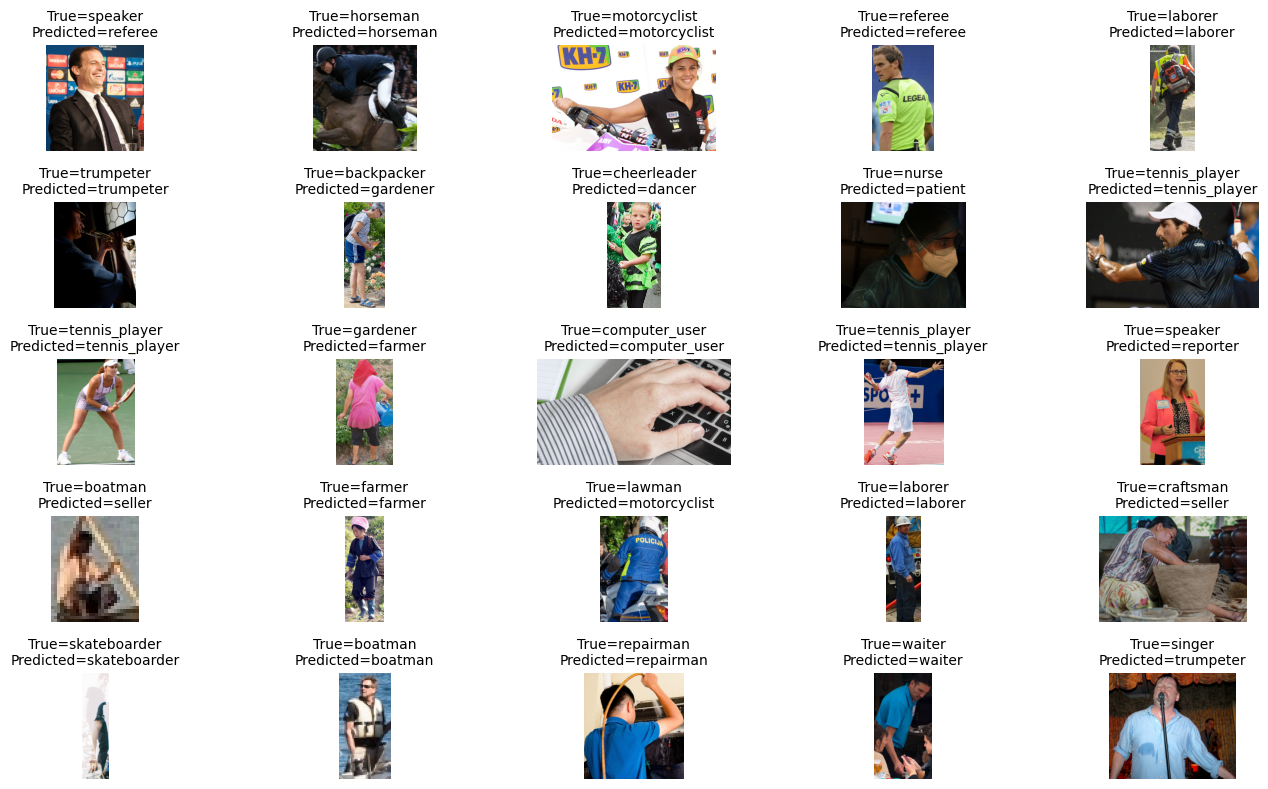

In [115]:
# Plot examples
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 8))
axes = axes.flatten()

for row in range(25):
    filepath = df['filepath'][row]
    img = Image.open(filepath)
    
    # Apply bounding box around person
    j_start = int(round(df.iloc[row]['bounding_box']['x']))
    i_start = int(round(df.iloc[row]['bounding_box']['y']))
    i_end = i_start + int(round(df.iloc[row]['bounding_box']['height']))
    j_end = j_start + int(round(df.iloc[row]['bounding_box']['width']))
    img = np.array(img)[i_start:i_end+1, j_start:j_end+1]

    # Plot
    axes[row].imshow(img)
    axes[row].axis('off')
    axes[row].set_title(f"True={df.iloc[row]['class1']}\nPredicted={classes[class_pred[row]]}", size=10)
    
plt.tight_layout();